In [ ]:
# Reinstalar numpy en versión compatible
!pip install numpy==1.23.5 --quiet

# Reinstalar mediapipe para que se compile correctamente con esa versión
!pip install mediapipe --force-reinstall --no-cache-dir --quiet

# Reiniciar el kernel automáticamente (esto es necesario para que funcione correctamente)
import os
os.kill(os.getpid(), 9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 81.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, b

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/entrenamiento/letras_movimiento.zip'  # Ajusta la ruta si es necesario
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# ========== CONFIGURACIÓN ==========
import cv2
import mediapipe as mp
import numpy as np
from tqdm import tqdm
import os
import pickle
from sklearn.preprocessing import LabelEncoder

ruta_videos = '/content/dataset'  # Ajusta si cambia
secuencia_maxima = 30
salto_frames = 5  # Cada cuánto empezar una nueva secuencia (puedes jugar con 5, 10, etc.)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.7)

X_data = []
y_labels = []

letras = sorted(os.listdir(ruta_videos))

for letra in tqdm(letras, desc="📦 Procesando letras"):
    carpeta_letra = os.path.join(ruta_videos, letra)
    for archivo in os.listdir(carpeta_letra):
        ruta_video = os.path.join(carpeta_letra, archivo)

        cap = cv2.VideoCapture(ruta_video)
        frames = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(frame_rgb)

            if results.multi_hand_landmarks:
                hand_landmarks = results.multi_hand_landmarks[0]
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                frames.append(landmarks)

        cap.release()

        # Extraer múltiples secuencias por video
        for inicio in range(0, len(frames) - secuencia_maxima + 1, salto_frames):
            secuencia = frames[inicio:inicio+secuencia_maxima]
            if len(secuencia) == secuencia_maxima:
                X_data.append(secuencia)
                y_labels.append(letra)

X_data = np.array(X_data)
y_labels = np.array(y_labels)

print(f"✅ Dataset generado con {X_data.shape[0]} ejemplos.")

# ========== Codificar las etiquetas ==========

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_labels)

# Guardar el encoder para después decodificar predicciones
import joblib
joblib.dump(encoder, '/content/label_encoder.pkl')

# ========== Guardar para entrenamiento ==========

with open("/content/features_secuencias.pkl", "wb") as f:
    pickle.dump((X_data, y_encoded), f)

print("✅ Datos y encoder guardados correctamente.")

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.0, so it will not be used.
  warnings.warn(
📦 Procesando letras: 100%|██████████| 7/7 [18:59<00:00, 162.75s/it]


✅ Dataset generado con 3624 ejemplos.
✅ Datos y encoder guardados correctamente.


In [ ]:
# ========== ENTRENAR UN MODELO LSTM ==========

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# ========== Cargar los datos ==========
with open("/content/features_secuencias.pkl", "rb") as f:
    X_data, y_labels = pickle.load(f)

print(f"✅ Datos cargados: {X_data.shape}, {y_labels.shape}")

# ========== Codificar las etiquetas ==========
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_labels)

# Guardamos el encoder para después decodificar predicciones
import joblib
joblib.dump(encoder, '/content/label_encoder.pkl')

# ========== Dividir en entrenamiento y validación ==========
X_train, X_val, y_train, y_val = train_test_split(X_data, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# ========== Definir el modelo ==========
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.4),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(encoder.classes_), activation='softmax')  # Tantas salidas como letras/clases
])

# ========== Compilar el modelo ==========
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# ========== Configurar early stopping ==========
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ========== Entrenar ==========
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

# ========== Guardar el modelo ==========
model.save('/content/modelo_letras_lstm.h5')

print("✅ Modelo entrenado y guardado correctamente.")

✅ Datos cargados: (3624, 30, 63), (3624,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1741 - loss: 1.9349 - val_accuracy: 0.2621 - val_loss: 1.8550
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2575 - loss: 1.8477 - val_accuracy: 0.3531 - val_loss: 1.6312
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3859 - loss: 1.5896 - val_accuracy: 0.4069 - val_loss: 1.4935
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4123 - loss: 1.4981 - val_accuracy: 0.5903 - val_loss: 1.1620
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5208 - loss: 1.2713 - val_accuracy: 0.5641 - val_loss: 1.0798
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5888 - loss: 1.1067 - val_accuracy: 0.7034 - val_loss: 0.8420
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6415 - loss: 0.9789 - val_accuracy: 0.7600 - val_loss: 0.7423
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7026 - loss: 0.8497 - val_accuracy: 0.71

✅ Modelo entrenado y guardado correctamente.


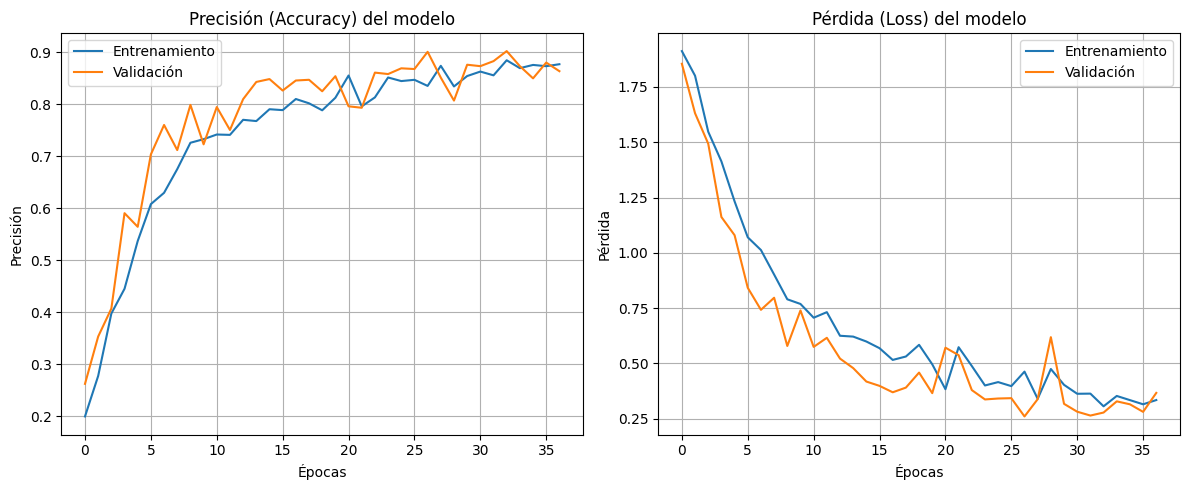

✅ Última accuracy entrenamiento: 0.8769
✅ Última accuracy validación: 0.8634


In [ ]:
import matplotlib.pyplot as plt

# ====== Graficar Accuracy ======
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión (Accuracy) del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# ====== Graficar Loss ======
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss) del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ====== Imprimir último accuracy ======
print(f"✅ Última accuracy entrenamiento: {history.history['accuracy'][-1]:.4f}")
print(f"✅ Última accuracy validación: {history.history['val_accuracy'][-1]:.4f}")